In [85]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

# data prep
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# models
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# metrics
from sklearn.metrics import mean_squared_error

First, keep only the records where ocean_proximity is either `'<1H OCEAN'` or `'INLAND'`

In [42]:
df = pd.read_csv('../data/housing.csv')
values = df.ocean_proximity.value_counts().head(2).index
df = df.query('ocean_proximity in @values')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [43]:
# check if query is correct
df.ocean_proximity.unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

Preparation:

* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [44]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [45]:
# 1. fill nulls with zeros
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [46]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [47]:
# log transformation for the median_house_value
df['mhv_log'] = np.log1p(df.median_house_value)

In [48]:
# split data 60/20/20
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [49]:
# check the split
df_train.shape[0], df_val.shape[0], df_test.shape[0]

(9411, 3138, 3138)

In [50]:
df.shape[0] == (df_train.shape[0] + df_val.shape[0] +df_test.shape[0])

True

In [51]:
# reset indexes
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [52]:
df_test.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,mhv_log
0,-122.02,37.32,27.0,4336.0,754.0,2009.0,734.0,6.3923,348300.0,<1H OCEAN,12.760822
1,-121.32,37.97,43.0,2453.0,490.0,1093.0,438.0,2.9107,88800.0,INLAND,11.394153


In [54]:
cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity',]

In [55]:
# create a vectorizer and prepare X and y sets
dv = DictVectorizer(sparse=False)

# prepare dictionaries
dict_train = df_train[cols].to_dict(orient="records")
dict_val = df_val[cols].to_dict(orient="records")
dict_test = df_test[cols].to_dict(orient="records")

# get X_train, X_val, X_test
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

y_train = df_train.mhv_log.values
y_val = df_val.mhv_log.values
y_test = df_test.mhv_log.values

In [56]:
y_train.shape[0]

9411

In [57]:
y_train[:5]

array([11.80634853, 12.68168862, 11.61187447, 12.03291497, 11.96145645])

In [58]:
X_train[:5]

array([[ 6.8000e+01,  1.3000e+01,  3.7930e+01, -1.2025e+02,  3.3750e+00,
         0.0000e+00,  1.0000e+00,  1.9600e+02,  7.6000e+01,  4.9300e+02],
       [ 2.6800e+02,  1.0000e+01,  3.4000e+01, -1.1840e+02,  5.8083e+00,
         1.0000e+00,  0.0000e+00,  7.0500e+02,  3.3900e+02,  1.5260e+03],
       [ 1.2200e+02,  4.6000e+01,  3.8850e+01, -1.2167e+02,  1.7417e+00,
         0.0000e+00,  1.0000e+00,  4.1000e+02,  1.3100e+02,  6.4500e+02],
       [ 8.8100e+02,  2.4000e+01,  3.3880e+01, -1.1814e+02,  2.6641e+00,
         1.0000e+00,  0.0000e+00,  2.0850e+03,  9.8200e+02,  3.3050e+03],
       [ 2.6400e+02,  3.4000e+01,  3.3920e+01, -1.1811e+02,  4.1767e+00,
         1.0000e+00,  0.0000e+00,  9.8300e+02,  2.6300e+02,  1.4140e+03]])

In [59]:
X_train.shape

(9411, 10)

In [60]:
dv.get_feature_names()

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity` <- correct
* `total_rooms`
* `latitude`
* `population`

In [61]:
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [62]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245 <- correct
* 0.545
* 0.845

In [66]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)).round(3)

0.245

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50 <- correct
- 160

In [67]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred)).round(3)
    scores.append((n, rmse))
scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
    
    

In [69]:
scores.head(7)

,n_estimators,rmse
0,10,0.245
1,20,0.238
2,30,0.236
3,40,0.235
4,50,0.234
5,60,0.234
6,70,0.234


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20 <- correct
* 25 <- correct

In [70]:
scores = []
for md in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred)).round(3)
        scores.append((n, md, rmse))

In [72]:
df_scores = pd.DataFrame(scores, columns=['n_estimators','max_depth', 'rmse'])

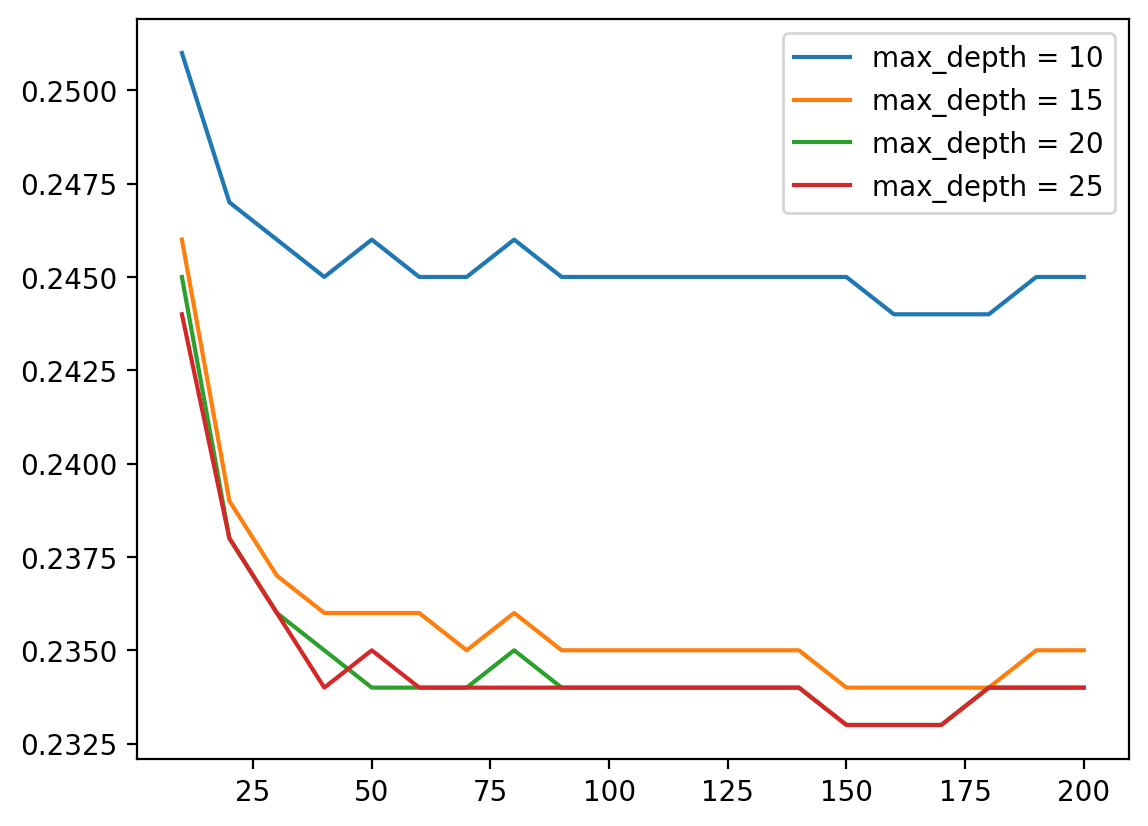

In [75]:
for md in [10, 15, 20, 25]:
    df_md = df_scores.query('max_depth == @md')
    plt.plot(df_md.n_estimators, df_md.rmse, label='max_depth = %d' % (md))
plt.legend()
plt.show()

In [80]:
df_scores.sort_values(by='rmse').head()

,n_estimators,max_depth,rmse
56,170,20,0.233
54,150,20,0.233
76,170,25,0.233
75,160,25,0.233
74,150,25,0.233


# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income` <- correct
* `total_bedrooms`
* `longitude`

In [81]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [82]:
rf.feature_importances_

array([0.01490478, 0.03004269, 0.10271687, 0.08579061, 0.33550704,
       0.21881985, 0.14745955, 0.02821151, 0.01522764, 0.02131944])

In [84]:
fi = list(zip(dv.feature_names_, rf.feature_importances_))
pd.DataFrame(fi, columns=['feature', 'gain']).sort_values(by='gain', ascending=False).head(3)

,feature,gain
4,median_income,0.335507
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3 <- correct
* 0.1
* Both give equal value

In [91]:
features = dv.get_feature_names()
features[5] = 'ocean_proximity=OCEAN'

In [92]:

# matrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
# create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [86]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [95]:
model = xgb.train(xgb_params, 
                    dtrain, 
                    evals=watchlist,
                    verbose_eval = 10,
                    num_boost_round=100)

[0]	train-rmse:0.44350	val-rmse:0.44250
[10]	train-rmse:0.21444	val-rmse:0.25179
[20]	train-rmse:0.18524	val-rmse:0.23978
[30]	train-rmse:0.16888	val-rmse:0.23570
[40]	train-rmse:0.15542	val-rmse:0.23318
[50]	train-rmse:0.14536	val-rmse:0.23225
[60]	train-rmse:0.13719	val-rmse:0.23139
[70]	train-rmse:0.12943	val-rmse:0.23068
[80]	train-rmse:0.12192	val-rmse:0.22886
[90]	train-rmse:0.11496	val-rmse:0.22861
[99]	train-rmse:0.10989	val-rmse:0.22862


In [97]:
y_pred_eta03 = model.predict(dval)

In [98]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, 
                    dtrain, 
                    evals=watchlist,
                    verbose_eval = 10,
                    num_boost_round=100)
y_pred_eta01 = model.predict(dval)

[0]	train-rmse:0.52449	val-rmse:0.52045
[10]	train-rmse:0.30326	val-rmse:0.31427
[20]	train-rmse:0.24512	val-rmse:0.26882
[30]	train-rmse:0.21887	val-rmse:0.25266
[40]	train-rmse:0.20392	val-rmse:0.24539
[50]	train-rmse:0.19215	val-rmse:0.24020
[60]	train-rmse:0.18457	val-rmse:0.23791
[70]	train-rmse:0.17741	val-rmse:0.23622
[80]	train-rmse:0.17242	val-rmse:0.23453
[90]	train-rmse:0.16797	val-rmse:0.23332
[99]	train-rmse:0.16323	val-rmse:0.23209


In [102]:
print('ETA = 0.3, RMSE =', np.sqrt(mean_squared_error(y_val, y_pred_eta03)).round(3))
print('ETA = 0.1, RMSE =', np.sqrt(mean_squared_error(y_val, y_pred_eta01)).round(3))

ETA = 0.3, RMSE = 0.229
ETA = 0.1, RMSE = 0.232
